In [6]:
#dataset preprocessing

import pandas as pd
import numpy as np
from scipy.stats import norm

df = pd.read_csv('Indian Liver Patient Dataset (ILPD).csv')
 
#add header
headerList = ['age', 'sex', 'total_Bilirubin', 'direct_Bilirubin', 'tp', 'albumin', 'AG_atio', 'SGPT', 'SGOT', 'Alkphos','Target'] 
df.to_csv("liver_trainset.csv", header=headerList, index=False)

In [2]:
# Stats of current dataset
import pandas as pd
import numpy as np
from scipy.stats import norm

df = pd.read_csv('trainset.csv')

# Compute statistics for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_stats = df[numeric_columns].describe()

# Compute statistics for gender column
gender_ratio = df['gender'].value_counts(normalize=True)

# Print the statistics
print("Numeric Columns Statistics:")
print(numeric_stats)

print("\nGender Ratio:")
print(gender_ratio)

KeyError: 'gender'

Accuracy on validation dataset: 0.7428571428571429
Accuracy on train dataset: 0.7051597051597052
Model coefficients:

[[-0.10019113  0.06806923 -0.2046088  -0.25094786 -0.2269933  -0.19542899
  -0.16950962 -0.0651696   0.10698484  0.09092474]]
            feature         VIF
0   total_Bilirubin    5.477514
1  direct_Bilirubin    5.702994
2                tp    2.600022
3           albumin    3.291986
4           AG_atio    3.192141
5              SGPT   69.593748
6              SGOT  111.911649
7           Alkphos   22.474278


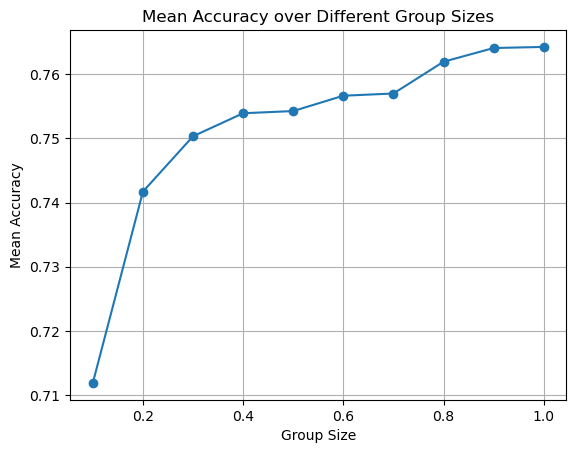

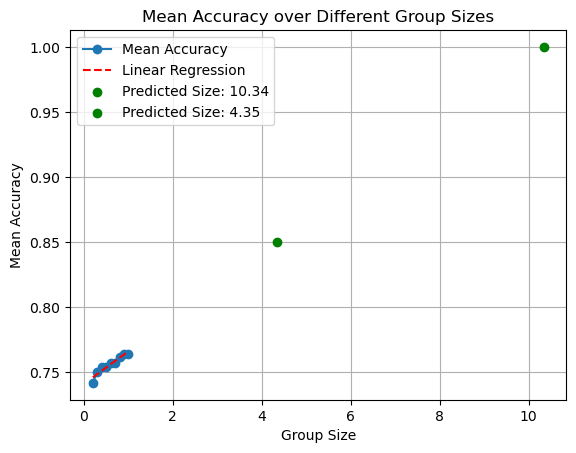

Predicted Group Size when Accuracy reaches 1.0: 10.34
Predicted Group Size when Accuracy reaches 0.85: 4.35


In [8]:
# do 80 - 20 split but make sure the gender proportion remain the same in both sets

# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#metrics and preprocess
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from statsmodels.stats.outliers_influence import variance_inflation_factor 

data = pd.read_csv('trainset.csv')
sex_mapping = {"Male": 0, "Female": 1}
data["sex"] = data["sex"].map(sex_mapping)

columns_to_normalize = ['total_Bilirubin','direct_Bilirubin','tp','albumin','AG_atio','SGPT','SGOT','Alkphos']

# print(data)
def modelfunction (data):
    X = data.drop('Target', axis=1)
    y = data['Target']
    X = scale(X)
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LogisticRegression(C=0.018, solver='lbfgs',penalty='l2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy on validation dataset: {accuracy_score(y_test,y_pred)}")
    y_pred = model.predict(X_train)
    print(f"Accuracy on train dataset: {accuracy_score(y_train,y_pred)}")
    print("Model coefficients:\n")
    print(model.coef_)
modelfunction(data)
# the independent variables set 
X = data[['total_Bilirubin','direct_Bilirubin','tp','albumin','AG_atio','SGPT','SGOT','Alkphos']] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)
# group level influence
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
# Define a function to randomly select different group sizes from the training set

X = data.drop('Target', axis=1)
y = data['Target']
def select_group(data, size,j):
    return data.sample(frac=size, random_state=42+j)

# Define a function to train the model 100 times for each group size and calculate mean and variance of accuracy
def train_model_multiple_times(X_train, y_train, X_test, y_test, sizes):
    accuracies = []
    for size in sizes:
        size_accuracies = []
        for j in range(100):  # Train the model 100 times
            X_train_sample = select_group(X_train, size,j)
            y_train_sample = y_train[X_train_sample.index]
            
            model = LogisticRegression(solver='liblinear')
            model.fit(X_train_sample, y_train_sample)
            
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            size_accuracies.append(accuracy)
        accuracies.append((np.mean(size_accuracies), np.var(size_accuracies)))
    return accuracies

# Splitting the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Define different group sizes
sizes = np.arange(0.1, 1.1, 0.1)

# Train the model multiple times for each group size and calculate mean and variance of accuracy
results = train_model_multiple_times(X_train, y_train, X_test, y_test, sizes)

# Extract mean accuracies and variances
mean_accuracies = [result[0] for result in results]
variances = [result[1] for result in results]

# Plot mean accuracy over different group sizes
plt.plot(sizes, mean_accuracies, marker='o')
plt.title('Mean Accuracy over Different Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()
plt.close()
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Mean accuracy values and group sizes
mean_accuracies = np.array(mean_accuracies[1:])  # Drop the first value
sizes = sizes[1:]  # Drop the first value

# Fit linear regression model
model = LinearRegression()
model.fit(sizes.reshape(-1, 1), mean_accuracies.reshape(-1, 1))

# Predict the group size where accuracy reaches 1.0
predicted_size = (1.0 - model.intercept_) / model.coef_[0]
predicted_size2 = (0.85 - model.intercept_) / model.coef_[0]

# Plot mean accuracy and linear regression
plt.plot(sizes, mean_accuracies, marker='o', label='Mean Accuracy')
plt.plot(sizes, model.predict(sizes.reshape(-1, 1)), color='red', linestyle='--', label='Linear Regression')
plt.scatter(predicted_size, 1.0, color='green', label=f'Predicted Size: {predicted_size[0]:.2f}', zorder=5)
plt.scatter(predicted_size2, 0.85, color='green', label=f'Predicted Size: {predicted_size2[0]:.2f}', zorder=5)
plt.title('Mean Accuracy over Different Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Predicted Group Size when Accuracy reaches 1.0: {predicted_size[0]:.2f}")
print(f"Predicted Group Size when Accuracy reaches 0.85: {predicted_size2[0]:.2f}")

In [9]:
# preprocess for heart disease
import pandas as pd
import numpy as np
from scipy.stats import norm
#14th col is class, 0 is none, >0 is infected, type: int64
df2 = pd.read_csv('heartdisease.data')
column_14 = df2.iloc[:, 13]
# assign name to columns
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
                'slope', 'ca', 'thal', 'target']

# assign column names
df2.columns = column_names

# map 2,3,4 into 1s
def map_values(value):
    if value >= 1:
        return 1
    else:
        return value

# apply mapping function to the column
df2['Target'] = df2['target'].map(map_values)
df2.to_csv('heart_trainset.csv')

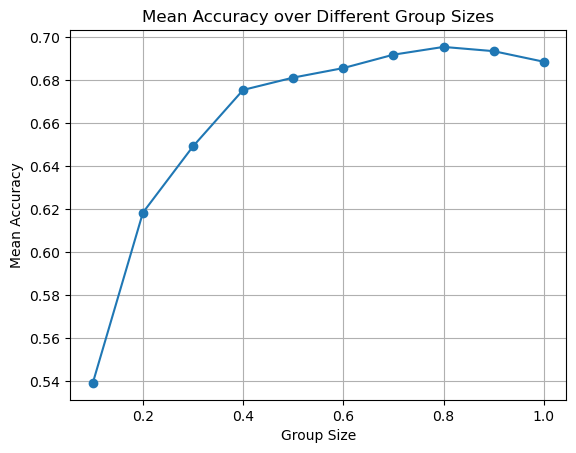

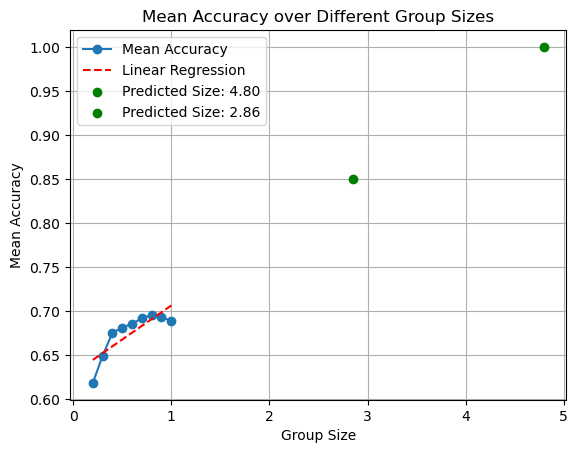

Predicted Group Size when Accuracy reaches 1.0: 4.80
Predicted Group Size when Accuracy reaches 0.85: 2.86


In [12]:
# group level influence
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
# Define a function to randomly select different group sizes from the training set
data = pd.read_csv('heart_trainset.csv')
X = data.drop('target', axis=1)
y = data['target']
def select_group(data, size,j):
    return data.sample(frac=size, random_state=42+j)

# Define a function to train the model 100 times for each group size and calculate mean and variance of accuracy
def train_model_multiple_times(X_train, y_train, X_test, y_test, sizes):
    accuracies = []
    for size in sizes:
        size_accuracies = []
        for j in range(100):  # Train the model 100 times
            X_train_sample = select_group(X_train, size,j)
            y_train_sample = y_train[X_train_sample.index]
            
            model = LogisticRegression(solver='liblinear')
            model.fit(X_train_sample, y_train_sample)
            
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            size_accuracies.append(accuracy)
        accuracies.append((np.mean(size_accuracies), np.var(size_accuracies)))
    return accuracies

# Splitting the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Define different group sizes
sizes = np.arange(0.1, 1.1, 0.1)

# Train the model multiple times for each group size and calculate mean and variance of accuracy
results = train_model_multiple_times(X_train, y_train, X_test, y_test, sizes)

# Extract mean accuracies and variances
mean_accuracies = [result[0] for result in results]
variances = [result[1] for result in results]

# Plot mean accuracy over different group sizes
plt.plot(sizes, mean_accuracies, marker='o')
plt.title('Mean Accuracy over Different Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()
plt.close()
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Mean accuracy values and group sizes
mean_accuracies = np.array(mean_accuracies[1:])  # Drop the first value
sizes = sizes[1:]  # Drop the first value

# Fit linear regression model
model = LinearRegression()
model.fit(sizes.reshape(-1, 1), mean_accuracies.reshape(-1, 1))

# Predict the group size where accuracy reaches 1.0
predicted_size = (1.0 - model.intercept_) / model.coef_[0]
predicted_size2 = (0.85 - model.intercept_) / model.coef_[0]

# Plot mean accuracy and linear regression
plt.plot(sizes, mean_accuracies, marker='o', label='Mean Accuracy')
plt.plot(sizes, model.predict(sizes.reshape(-1, 1)), color='red', linestyle='--', label='Linear Regression')
plt.scatter(predicted_size, 1.0, color='green', label=f'Predicted Size: {predicted_size[0]:.2f}', zorder=5)
plt.scatter(predicted_size2, 0.85, color='green', label=f'Predicted Size: {predicted_size2[0]:.2f}', zorder=5)
plt.title('Mean Accuracy over Different Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Predicted Group Size when Accuracy reaches 1.0: {predicted_size[0]:.2f}")
print(f"Predicted Group Size when Accuracy reaches 0.85: {predicted_size2[0]:.2f}")